# Feature Selection and Classification Models for Hotel Cancellations

## Importing Packages and Loading the Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
booking = pd.read_csv(r'Documents\Clean Hotel Booking.csv')

In [3]:
booking.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,meal,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,total_nights,city_hotel,room_freq,transient_booking,from_Portugal,channel_freq,segment_freq
0,0,7,2015,7,27,1,1,0.0,0,1,0,0,0,0,2,0,75.0,0,0,1,0,0.719800,1,0,0.116977,0.104401
1,0,13,2015,7,27,1,1,0.0,0,1,0,0,0,0,2,0,75.0,0,0,1,0,0.719800,1,0,0.053957,0.043048
2,0,14,2015,7,27,1,2,0.0,0,1,0,0,0,0,2,0,98.0,0,1,2,0,0.719800,1,0,0.827407,0.479100
3,0,14,2015,7,27,1,2,0.0,0,1,0,0,0,0,2,0,98.0,0,1,2,0,0.719800,1,0,0.827407,0.479100
4,0,0,2015,7,27,1,2,0.0,0,1,0,0,0,0,2,0,107.0,0,0,2,0,0.007806,1,1,0.116977,0.104401


## Train Test Split

In [4]:
X = booking.drop('is_canceled',axis=1)
y = booking['is_canceled']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

X_train.shape, X_test.shape

((81874, 25), (35089, 25))

## Correlation for Feature Selection
Removing dependent features that have high correlation values with each other. 

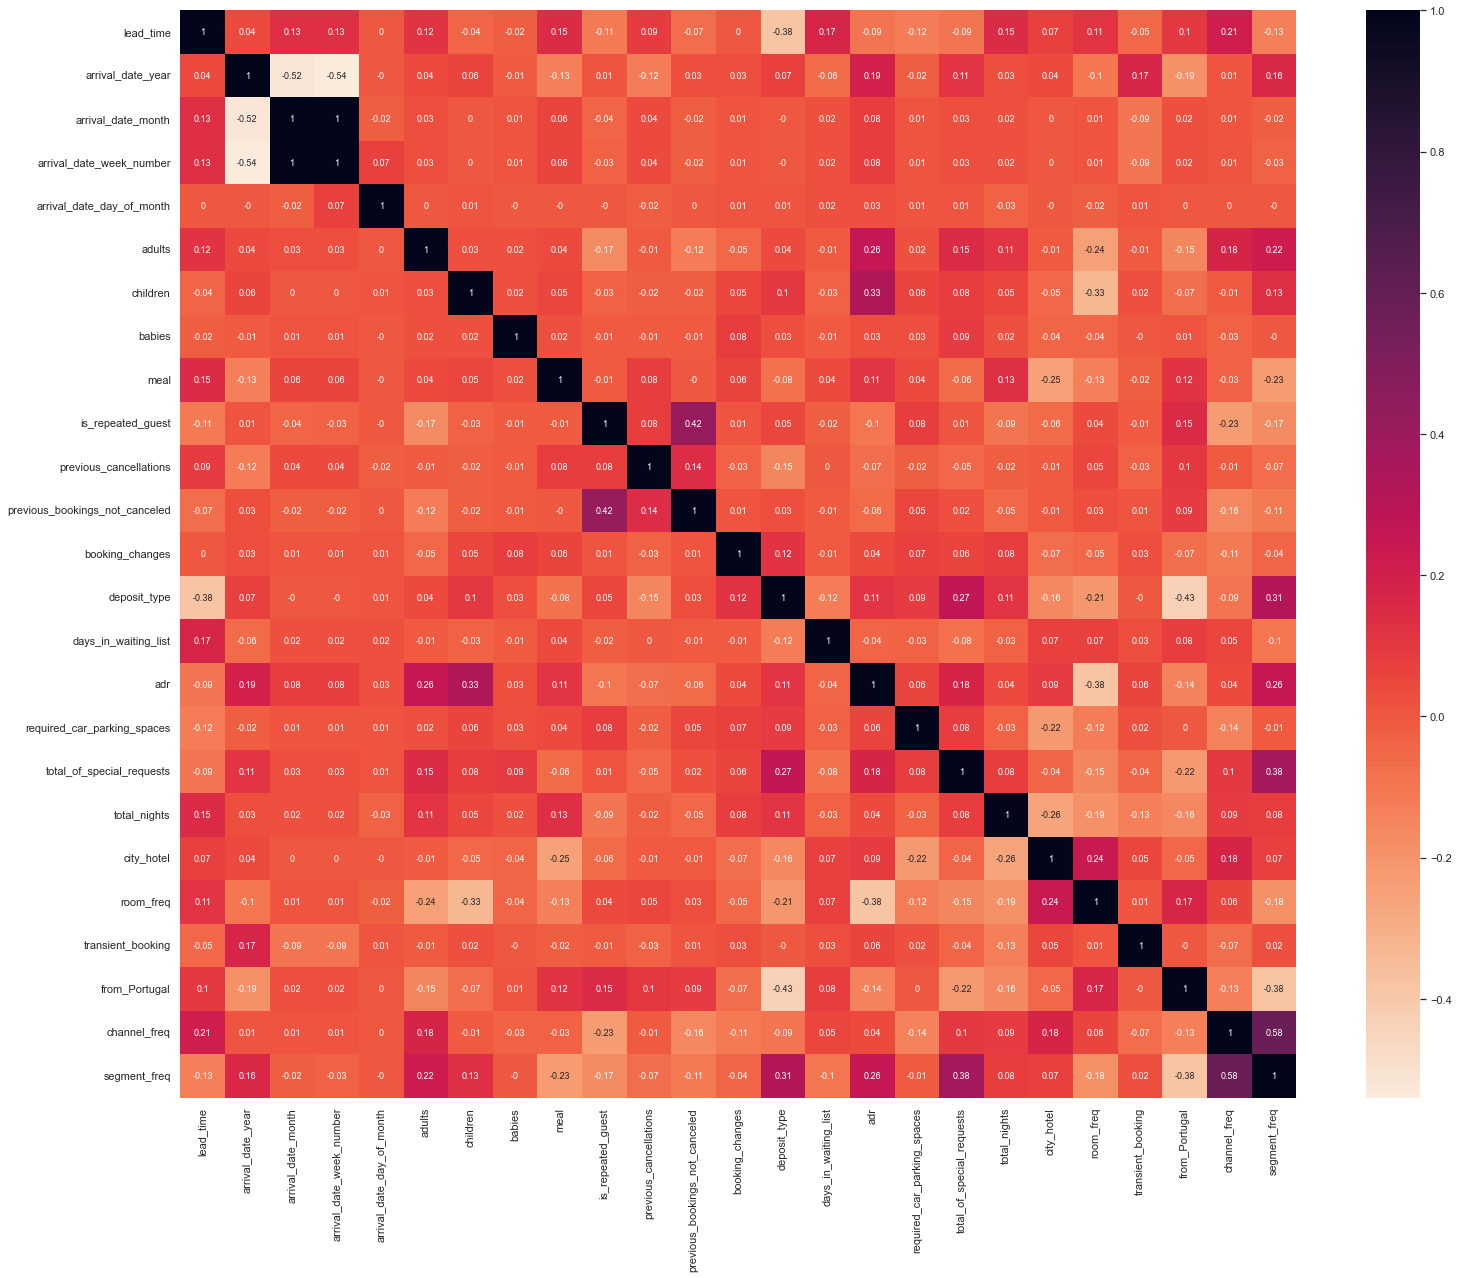

In [6]:
plt.figure(figsize=(25,20))
corr_df = X_train.corr().round(2)
sns.heatmap(corr_df, annot=True, cmap='rocket_r', annot_kws={"fontsize":9})
plt.show()

In [7]:
def correlation(df, threshold):
    col_corr = set()
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [8]:
corr_features = correlation(X_train, 0.7)
print('Number of features to drop:', len(set(corr_features)))

Number of features to drop: 1


In [9]:
print('\033[1m' + 'Features to Drop')
for feature in corr_features:
    print('\033[0m' + feature)


Features to Drop
arrival_date_week_number


In [10]:
X_train.drop(corr_features, axis=1, inplace=True)
X_test.drop(corr_features, axis=1, inplace=True)

## Mutual Information for Feature Selection

In [11]:
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

array([0.07837368, 0.00553222, 0.        , 0.00243844, 0.00928595,
       0.        , 0.00118188, 0.00718694, 0.00485703, 0.04318532,
       0.00761365, 0.02006738, 0.14234972, 0.01511103, 0.07325821,
       0.03235548, 0.0388584 , 0.01130458, 0.01398165, 0.00856071,
       0.0082884 , 0.06412935, 0.0203488 , 0.03703272])

In [12]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

deposit_type                      0.142350
lead_time                         0.078374
adr                               0.073258
from_Portugal                     0.064129
previous_cancellations            0.043185
total_of_special_requests         0.038858
segment_freq                      0.037033
required_car_parking_spaces       0.032355
channel_freq                      0.020349
booking_changes                   0.020067
days_in_waiting_list              0.015111
city_hotel                        0.013982
total_nights                      0.011305
adults                            0.009286
room_freq                         0.008561
transient_booking                 0.008288
previous_bookings_not_canceled    0.007614
meal                              0.007187
arrival_date_year                 0.005532
is_repeated_guest                 0.004857
arrival_date_day_of_month         0.002438
babies                            0.001182
children                          0.000000
arrival_dat

In [13]:
print('Number of features to drop:', (mutual_info < 0.01).sum())

Number of features to drop: 11


In [14]:
selected_cols = SelectKBest(mutual_info_classif, k= (mutual_info > 0.01).sum())
selected_cols.fit(X_train, y_train)

SelectKBest(k=13,
            score_func=<function mutual_info_classif at 0x000001E2AF08AF70>)

In [15]:
dropped_columns = [col for col in X_train.columns 
                   if col not in X_train.columns[selected_cols.get_support()]]

In [16]:
print('\033[1m' + 'Features to Drop')
for feature in dropped_columns:
    print('\033[0m' + feature)

Features to Drop
arrival_date_year
arrival_date_month
arrival_date_day_of_month
adults
children
babies
meal
is_repeated_guest
previous_bookings_not_canceled
total_nights
room_freq


In [17]:
X_train.drop(dropped_columns,axis=1,inplace=True)
X_test.drop(dropped_columns,axis=1,inplace=True)

In [18]:
evaluation_metrics = pd.DataFrame({'Model':["Logistic Regression", "Random Forest", "XGBoost"], \
                                   "Accuracy":[0, 0, 0], "Cancelled Precision":[0,0,0],
                                   "Cancelled Recall": [0,0,0]})
evaluation_metrics

,Model,Accuracy,Cancelled Precision,Cancelled Recall
0,Logistic Regression,0,0,0
1,Random Forest,0,0,0
2,XGBoost,0,0,0


## Logistic Regression

In [19]:
lr = LogisticRegression(random_state=42)

lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [20]:
y_pred_lr = lr.predict(X_test)
logistic_score = lr.score(X_test, y_test)
print('Logistic Regression accuracy on the test set is: {:.2f}'.format(logistic_score))

Logistic Regression accuracy on the test set is: 0.79


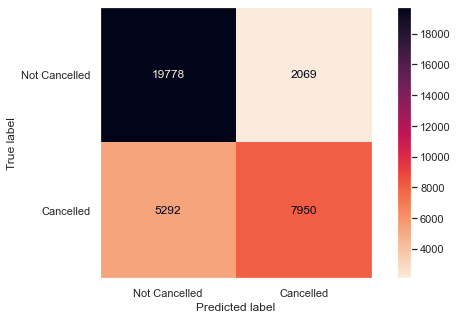

In [21]:
fig, ax = plt.subplots(figsize=(9,5))

plt.grid(False)
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_lr),
    display_labels = ['Not Cancelled','Cancelled'],
)
cmp.plot(ax=ax, cmap='rocket_r', values_format = 'd');

In [22]:
print(classification_report(y_test, y_pred_lr, target_names = ['Not Cancelled','Cancelled']))

               precision    recall  f1-score   support

Not Cancelled       0.79      0.91      0.84     21847
    Cancelled       0.79      0.60      0.68     13242

     accuracy                           0.79     35089
    macro avg       0.79      0.75      0.76     35089
 weighted avg       0.79      0.79      0.78     35089



In [23]:
lr_report = pd.DataFrame(classification_report(y_test, y_pred_lr, target_names = ['Not Cancelled','Cancelled'], output_dict=True))
lr_report

,Not Cancelled,Cancelled,accuracy,macro avg,weighted avg
precision,0.788911,0.793492,0.790219,0.791202,0.790640
recall,0.905296,0.600362,0.790219,0.752829,0.790219
f1-score,0.843106,0.683548,0.790219,0.763327,0.782891
support,21847.000000,13242.000000,0.790219,35089.000000,35089.000000


In [24]:
evaluation_metrics.iloc[0,1] = round(accuracy_score(y_test, y_pred_lr),2)
evaluation_metrics.iloc[0,2] = round(lr_report.iloc[0,1],2)
evaluation_metrics.iloc[0,3] = round(lr_report.iloc[1,1],2)

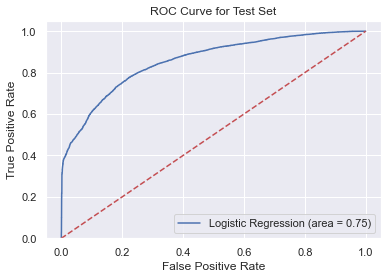

In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, lr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

**Thoughts**

We mostly care about how well we predict cancellations, so we will mainly focus on the recall score for Cancelled. The logistic regression does well in predicting non cancelled reservations, however, it performs much worse in predicting cancelled reservations, with a recall score of **0.60**.

## Random Forest

In [26]:
rf = RandomForestClassifier(random_state=42, max_features=0.5)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

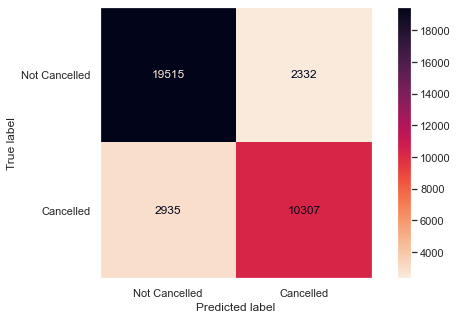

In [27]:
fig, ax = plt.subplots(figsize=(9,5))

plt.grid(False)
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_rf),
    display_labels = ['Not Cancelled','Cancelled']
)
cmp.plot(ax=ax, cmap='rocket_r', values_format = 'd');

In [28]:
print(classification_report(y_test, y_pred_rf, target_names = ['Not Cancelled','Cancelled']))

               precision    recall  f1-score   support

Not Cancelled       0.87      0.89      0.88     21847
    Cancelled       0.82      0.78      0.80     13242

     accuracy                           0.85     35089
    macro avg       0.84      0.84      0.84     35089
 weighted avg       0.85      0.85      0.85     35089



In [29]:
rf_report = pd.DataFrame(classification_report(y_test, y_pred_rf, target_names = ['Not Cancelled','Cancelled'], output_dict=True))
rf_report

,Not Cancelled,Cancelled,accuracy,macro avg,weighted avg
precision,0.869265,0.815492,0.849896,0.842378,0.848972
recall,0.893258,0.778357,0.849896,0.835807,0.849896
f1-score,0.881098,0.796492,0.849896,0.838795,0.849169
support,21847.000000,13242.000000,0.849896,35089.000000,35089.000000


In [30]:
evaluation_metrics.iloc[1,1] = round(accuracy_score(y_test, y_pred_rf),2)
evaluation_metrics.iloc[1,2] = round(rf_report.iloc[0,1],2)
evaluation_metrics.iloc[1,3] = round(rf_report.iloc[1,1],2)

## XGBoost Classification

In [31]:
import xgboost as xgb

In [32]:
xgb_cl = xgb.XGBClassifier(random_state=42)

In [33]:
xgb_cl.fit(X_train, y_train)

xg_pred = xgb_cl.predict(X_test)

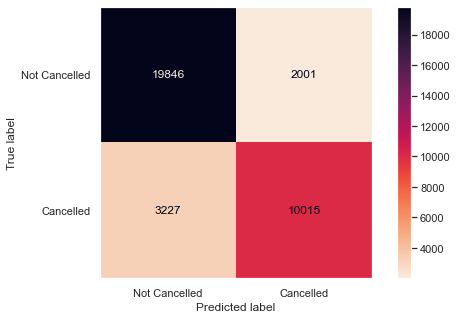

In [34]:
fig, ax = plt.subplots(figsize=(9,5))

plt.grid(False)
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, xg_pred),
    display_labels = ['Not Cancelled','Cancelled']
)
cmp.plot(ax=ax, cmap='rocket_r', values_format = 'd');

In [35]:
print(classification_report(y_test, xg_pred, target_names = ['Not Cancelled','Cancelled']))

               precision    recall  f1-score   support

Not Cancelled       0.86      0.91      0.88     21847
    Cancelled       0.83      0.76      0.79     13242

     accuracy                           0.85     35089
    macro avg       0.85      0.83      0.84     35089
 weighted avg       0.85      0.85      0.85     35089



### Hyperparameter Tuning for XGBoost

In [36]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
    "scale_pos_weight" : [1.7]
}

In [37]:
xgb_cl = xgb.XGBClassifier()

In [38]:
random_search = RandomizedSearchCV(xgb_cl, param_distributions=params, scoring = 'recall',
                                   n_iter=5, n_jobs=-1, verbose=1, random_state=42)

In [39]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_c...
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'scale_pos_weight': [1.7]},
                   random_state=42, scoring='recall', verbose=1)

In [40]:
random_search.best_params_

{'scale_pos_weight': 1.7,
 'min_child_weight': 5,
 'max_depth': 6,
 'learning_rate': 0.25,
 'gamma': 0.1,
 'colsample_bytree': 0.4}

In [41]:
xg_pred = random_search.predict(X_test)

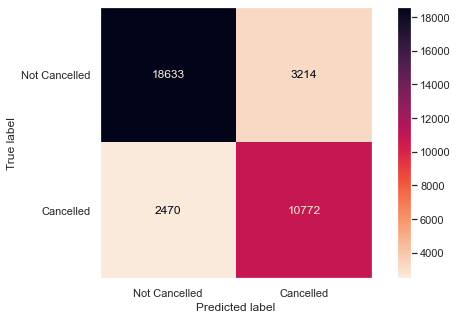

In [42]:
fig, ax = plt.subplots(figsize=(9,5))

plt.grid(False)
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, xg_pred),
    display_labels = ['Not Cancelled','Cancelled']
)
cmp.plot(ax=ax, cmap='rocket_r', values_format = 'd');

In [43]:
print(classification_report(y_test, xg_pred, target_names = ['Not Cancelled','Cancelled']))

               precision    recall  f1-score   support

Not Cancelled       0.88      0.85      0.87     21847
    Cancelled       0.77      0.81      0.79     13242

     accuracy                           0.84     35089
    macro avg       0.83      0.83      0.83     35089
 weighted avg       0.84      0.84      0.84     35089



In [44]:
xg_report = pd.DataFrame(classification_report(y_test, xg_pred, target_names = ['Not Cancelled','Cancelled'], output_dict=True))
xg_report

,Not Cancelled,Cancelled,accuracy,macro avg,weighted avg
precision,0.882955,0.770199,0.838012,0.826577,0.840403
recall,0.852886,0.813472,0.838012,0.833179,0.838012
f1-score,0.867660,0.791244,0.838012,0.829452,0.838822
support,21847.000000,13242.000000,0.838012,35089.000000,35089.000000


In [45]:
evaluation_metrics.iloc[2,1] = round(accuracy_score(y_test, xg_pred),2)
evaluation_metrics.iloc[2,2] = round(xg_report.iloc[0,1],2)
evaluation_metrics.iloc[2,3] = round(xg_report.iloc[1,1],2)

## Comparing Models

In [46]:
evaluation_metrics

,Model,Accuracy,Cancelled Precision,Cancelled Recall
0,Logistic Regression,0.79,0.79,0.60
1,Random Forest,0.85,0.82,0.78
2,XGBoost,0.84,0.77,0.81


**Thoughts**

While the Random Forest and XGBoost show good overall accuracy scores, both models score a little bit lower when it comes to recall. These two models can help inform us on the patterns to look for in spotting cancellations, but we might want our recall score to be a bit higher before deploying so that we can maximize revenue and minimize vacancies.

## Feature Importance

In [47]:
xg_importances = random_search.best_estimator_.feature_importances_

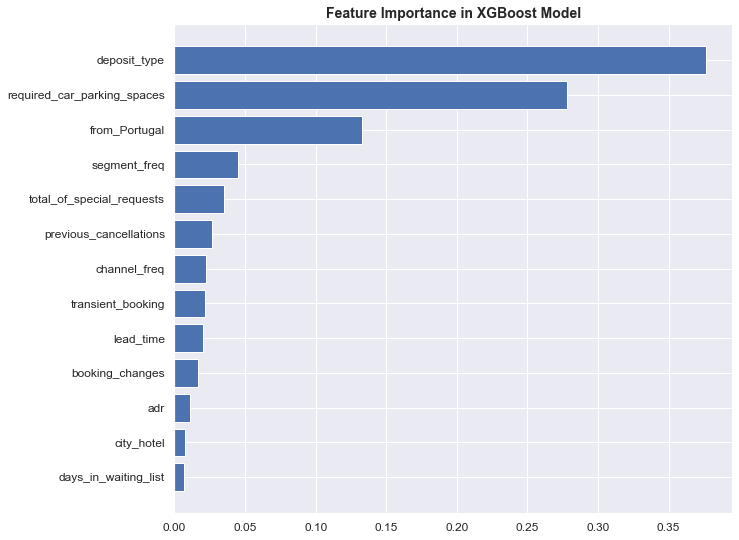

In [54]:
sorted_idx = xg_importances.argsort()

fig = plt.figure(figsize=(10,9))
plt.barh(X_train.columns[sorted_idx], xg_importances[sorted_idx])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Feature Importance in XGBoost Model', fontsize=14, fontweight='bold')
plt.show()

**Thoughts**

The 3 most important features are the deposit type, the # of required parking spaces and the guest being from Portugal.
- Not having a deposit down for a hotel room likely frees the guest up to consider other accomodations without penalty, so the importance of the deposit type makes sense. 
- Arranging for required parking spaces likely suggests a guest is highly intent on visiting, or perhaps has more concrete travel plans that would be more difficult to cancel.
- For people in Portugal, travel plans are likely less cumbersome than those of other guests from out of the country, so it's understandable that Portuguese guests could more easily cancel their reservations. To remedy this, the hotel group could look to do more advertising and promotion in other top guest origins outside of Portugal.

## Ideas for Further Development

In the future, I hope to revisit this project to implement deep learning methods once I am more comfortable with the concepts. For feature engineering, I might want to experiment more with the encoding techniques (label, one-hot, frequency, etc.).

**Ideas for Additional Data** 
- Whether the reservation was booked through a promotion, if promotions do exist. 
- Gender of the guest booking the reservation.
- Indicator of whether the reservation dates coincide with any local or national holiday. If there is a holiday, there will likely be more travel and therefore a greater chance for cancellations.